In [4]:
# pip install pmdarima
# auto arima를 자동으로 찾아준다

In [31]:
# warning메시지 무시
import warnings
warnings.filterwarnings('ignore')


In [32]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pmdarima as pm

In [33]:
# 삼성주식 찾기

df_krx = fdr.StockListing('KRX')
df_krx.head(3)

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,68700,1,300,0.44,68100,68700,68000,2382490,162731166700,410124061185000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,576000,1,2000,0.35,574000,580000,572000,30235,17417274000,134784000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,97600,2,-300,-0.31,97400,97800,96600,425803,41346517500,71053030824000,728002365,STK


In [34]:
ticker=df_krx[df_krx['Name']=='삼성전자']['Code']

In [93]:
# 2020-01-01부터 삼성주가
ss=fdr.DataReader(''.join(ticker.values),'2020-01-01')

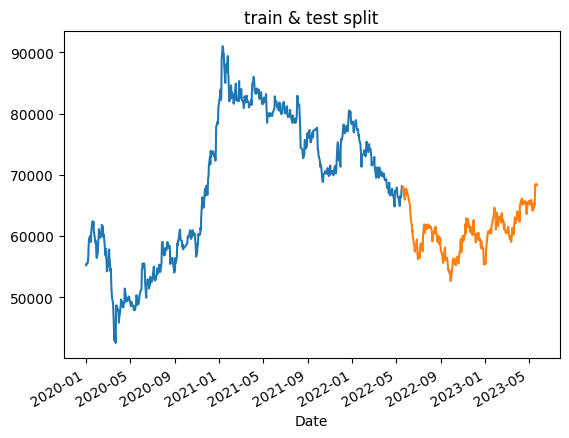

In [94]:
# train set, test set으로 구분하기(7:3)
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]
plt.subplot()
plt.title('train & test split')
y_train.plot()
y_test.plot()
plt.show()

In [95]:
# pmdarima.arima.ndiffs를 활용한 차분 필요 여부 및 추정차수

kpss_diffs=pm.arima.ndiffs(y_train,alpha=0.05,test='kpss',max_d=6)
adf_diffs=pm.arima.ndiffs(y_train,alpha=0.05,test='adf',max_d=6)
max(kpss_diffs,adf_diffs)

## 즉 arima모델에서 d를 1로 잡자

1

In [96]:
# log를 활용한 변동선 완화

ss_log=np.log(ss)

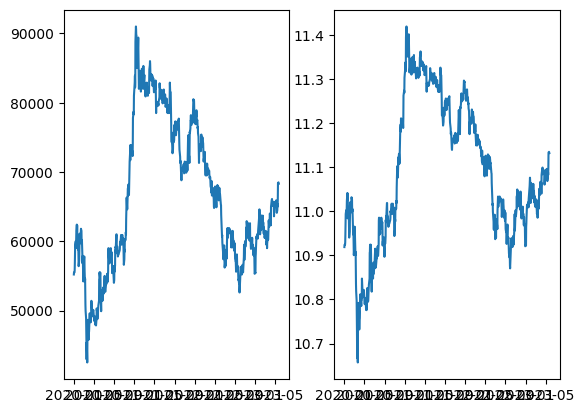

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(ss['Close'])

ax2.plot(ss_log['Close'])

plt.show()

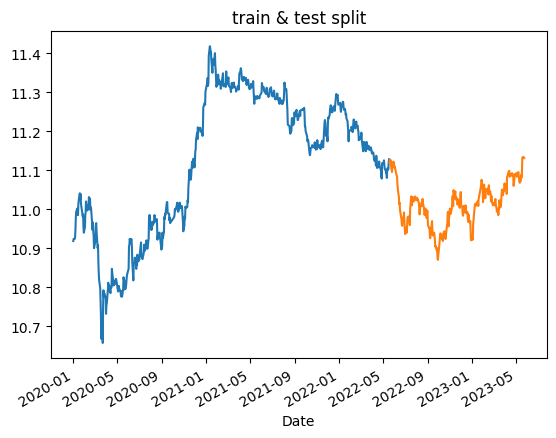

In [98]:
# train set, test set으로 구분하기(7:3)
y_train = ss_log['Close'][:int(0.7*len(ss))]
y_test = ss_log['Close'][int(0.7*len(ss)):]
plt.subplot()
plt.title('train & test split')
y_train.plot()
y_test.plot()
plt.show()

## 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

- AR(p) : ACF 가 완만하게 감소, PACF가 갑자기 cut-off
- MR(q) : ACF가 cut-off , PACF가 완만하게 감소
- ARMA(p,q) : ACF, PACF가 완만하게 감소

* p,q값에 주관이 들어갈 수 있다

### Augmented Dickey-Fuller test
- stationary를 확인해보는 방법
- from statsmodels.tsa.stattools import adfuller
-  p_value가 넘는지 안넘는지를 보면 된다
    - result = adfuller(inputSeries)
    - print('p-value: %f' % result[1])
- H0(귀무가설) : stationary 하지 않다
- H1(대립가설) : stationary 하다 
- 즉 p-value가 임계치보다 낮으면 H0를 기각하고, H1을 채택--> 즉 stationary하다

In [99]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

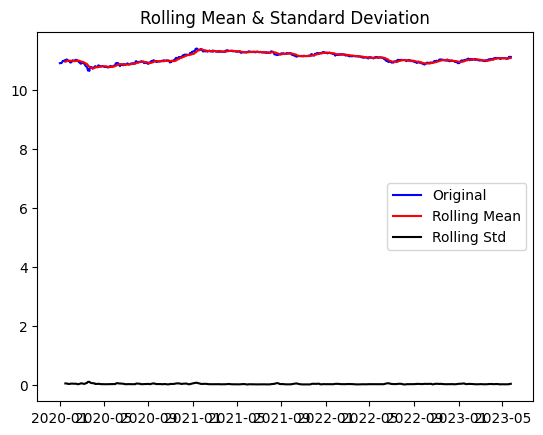

In [100]:
plot_rolling_statistics(ss_log['Close'])

In [101]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [102]:
augmented_dickey_fuller_test(ss_log['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.666055
p-value                          0.448682
#Lags Used                       0.000000
Number of Observations Used    839.000000
Critical Value (1%)             -3.438168
Critical Value (5%)             -2.864991
Critical Value (10%)            -2.568608
dtype: float64



정성적 그래프 분석 :


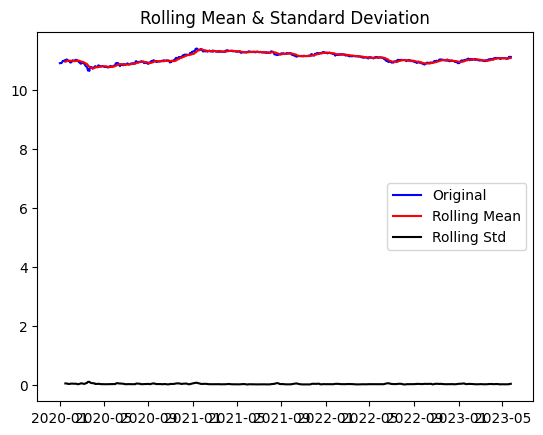


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                  -1.666055
p-value                          0.448682
#Lags Used                       0.000000
Number of Observations Used    839.000000
Critical Value (1%)             -3.438168
Critical Value (5%)             -2.864991
Critical Value (10%)            -2.568608
dtype: float64

시계열 분해 (Time Series Decomposition) :


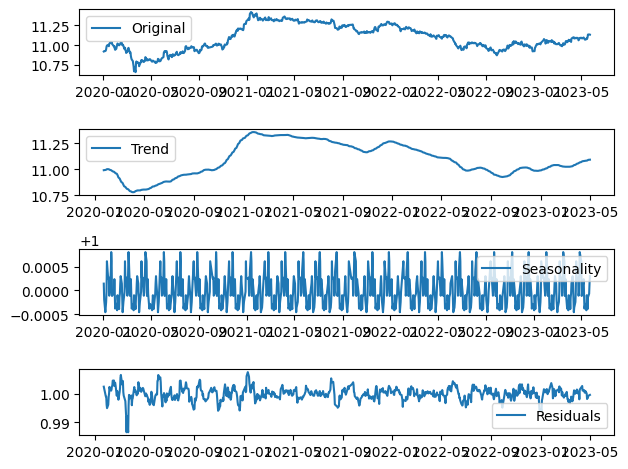

In [103]:
print()
print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')
# 정성적 그래프 분석
plot_rolling_statistics(ss_log['Close'], window=12)

print()
print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ss_log['Close'])

print()
print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ss_log['Close'], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ss_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

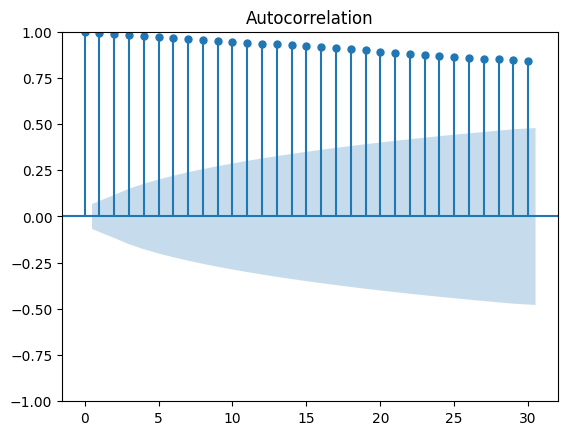

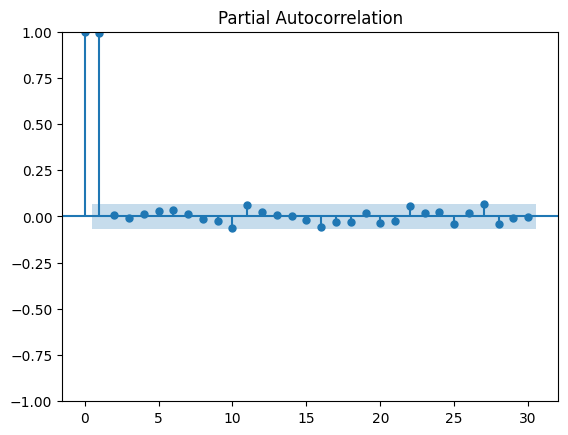

In [104]:
# ACF , PACF 그래프 확인
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ss_log['Close'])
plot_pacf(ss_log['Close'])
plt.show()

In [111]:
## AR(2)로 2번 차분을 할 예정(cut-off가 2이다)
## 차분을 통해서 정상성 확보
print('1차 차분')
diff_1 =ss_log.diff(periods=1)
diff_1=diff_1['Close'].iloc[1:]
#diff_1
augmented_dickey_fuller_test(diff_1)

1차 차분
Results of Dickey-Fuller Test:
Test Statistic                 -29.186517
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    838.000000
Critical Value (1%)             -3.438177
Critical Value (5%)             -2.864995
Critical Value (10%)            -2.568610
dtype: float64


In [114]:
print('2차 차분')
diff_2 =ss_log.diff(periods=1)
diff_2=diff_2['Close'].iloc[1:]
augmented_dickey_fuller_test(diff_2)


2차 차분
Results of Dickey-Fuller Test:
Test Statistic                 -29.186517
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    838.000000
Critical Value (1%)             -3.438177
Critical Value (5%)             -2.864995
Critical Value (10%)            -2.568610
dtype: float64


### pmdarima.arima.auto_arima
- pmdarima.arima.auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [115]:
model=pm.arima.auto_arima(
    y=y_train , d=1,
    start_P=0, max_p=3,
    start_Q=0, max_q=3,
    m=1, seasonal=False,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3114.255, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3120.627, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3118.628, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3118.626, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3122.363, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3117.174, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.440 seconds


In [116]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  588
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1562.182
Date:                Wed, 24 May 2023   AIC                          -3122.363
Time:                        11:03:10   BIC                          -3117.988
Sample:                             0   HQIC                         -3120.659
                                - 588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   1.02e-05     28.053      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               297.71
Prob(Q):                              0.97   Pr

### Ljung-Box(융박스)
- H0 (귀무가설):융박스가 백색잡음이다 ----> 그러면 stationary이다
- H1 (대립가설):융박스가 백색잡음이 아니다---> 그러면 stationary하지 않는다 --> 차분을 해야함

### Jarque-Bera(자크 베라)
- H0 (귀무가설): 정상성을 띄고 있다
- H1 (대립가설): 정상성을 띄고 있지 않다

### Heteroskedasticity
- H0 (귀무가설) : 이분산성을 띄고 있다
- H1 (대립가설) : 이분산성을 띄지 않는다(등분산성의 성질을 갖는다)

### Skew:
- 왜도(치우쳐진 정도, 0에 가까울수록 가운데에 모인다)
- 0에 가까우면 정규분포를 띈다

### Kurtosis
- 첨도(뾰족한 정도)
- 정규분포의 첨도는 3이다.
- 3보다 크면 뾰족해지고, 3보다 작으면 완만해진다

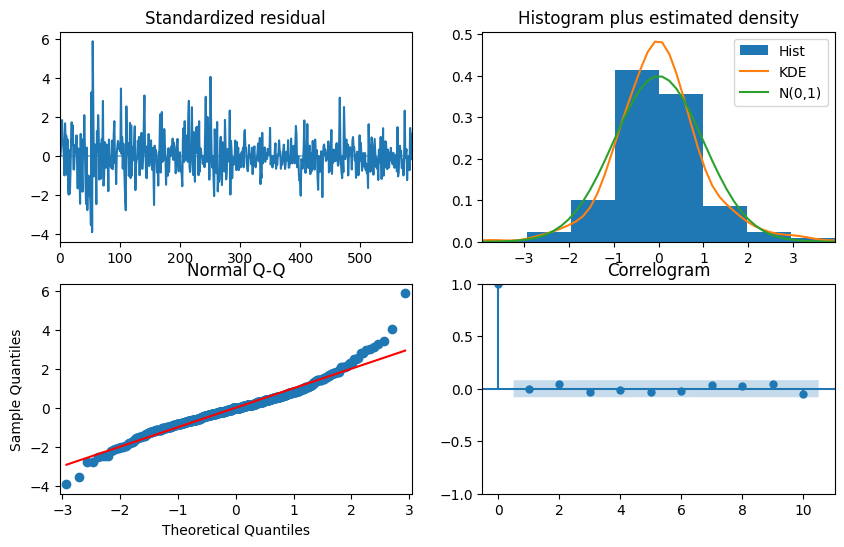

In [118]:
# model.plot_diagnostics 이용해서 그래프를 확인하기

model.plot_diagnostics(figsize=(10,6))
plt.show()

In [124]:
## 테스트 데이터를 통한 예측

y_predict = model.predict(n_periods=len(y_test))
y_predict_df= pd.DataFrame(y_predict.values,index=y_test.index,columns=['predictions'])
y_predict_df

,predictions
Date,
2022-05-19,11.128732
2022-05-20,11.128732
2022-05-23,11.128732
2022-05-24,11.128732
2022-05-25,11.128732
...,...
2023-05-18,11.128732
2023-05-19,11.128732
2023-05-22,11.128732


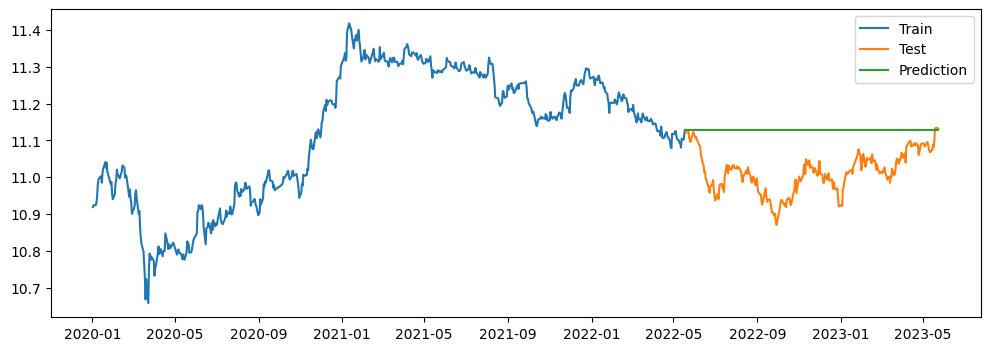

In [125]:
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [128]:
def forecast_one_step():
    fc,conf_int= model.predict(n_periods=1,return_conf_int=True)
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])

In [129]:
forcasts=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for new_ob in y_test:
    fc,conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## model update
    model.update(new_ob)

In [131]:
pd.DataFrame({"test":y_test,"pred":y_pred})

,test,pred
Date,,
2022-05-19,11.119883,11.128732
2022-05-20,11.127263,11.119883
2022-05-23,11.125791,11.127263
2022-05-24,11.104957,11.125791
2022-05-25,11.103452,11.104957
...,...,...
2023-05-18,11.100436,11.082143
2023-05-19,11.133128,11.100436
2023-05-22,11.134589,11.133128


In [133]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  840
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2259.287
Date:                Wed, 24 May 2023   AIC                          -4516.573
Time:                        13:16:52   BIC                          -4511.841
Sample:                             0   HQIC                         -4514.759
                                - 840                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   8.46e-06     31.703      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               301.71
Prob(Q):                              0.79   Pr

In [135]:
# pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [137]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()